# 1.  Brief description of the problem and data

### Challenge Problem

The task is to detect metastatic cancer in histopathologic images of lymph node tissue. Each image patch is labeled 1 (tumor present) or 0 (no tumor). The challenge is that cancer cells are small, irregular, and sometimes visually subtle, making classification difficult. A Convolutional Neural Network (CNN) is a natural choice because it can automatically learn discriminative local texture patterns (e.g., cell morphology, nuclei) as well as global context from image data.

### Data Characteristics

* Dataset Size:

    * ~220,025 labeled training images

    * ~57,458 test images (no labels, for submission)

* Image Dimensions:

    * Each image patch is 96 × 96 pixels, RGB (3 channels).

    * The label depends only on the central 32 × 32 region, though the surrounding context may provide useful cues.

* Structure:

    * Input: Raw .tif image patches (96×96×3).

    * Labels: Binary (0 = no tumor, 1 = tumor).

    * Imbalance: Typically, more negatives(40.5%) than positives(59.5%), so class-balancing or weighted loss is often needed.

### CNN for this Task

* Why CNN:

    * Convolutions are well-suited for spatial patterns in histology (edges, textures, color variations).

    * Pooling layers give translation/rotation tolerance, important since tissue sections vary in orientation.

    * Hierarchical features (from edges → cell clusters → tissue regions) align with pathology analysis.

* Output:

    * A single logit per image, passed through sigmoid to represent the probability of cancer in the center region.

# 2. Exploratory Data Analysis (EDA)

In [ ]:
# libraries
import cv2
from glob import glob
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook,trange, tqdm
import matplotlib.pyplot as plt

import gc

In [ ]:
# Show the data
path = "../input/"
train_path = path + 'train/'
test_path = path + 'test/'

df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))})
df['id'] = df.path.map(lambda x: x.split('/')[3].split(".")[0])
labels = pd.read_csv(path+"train_labels.csv")
df = df.merge(labels, on = "id")
df.head(3)

,path,id,label
0,../input/train/d43c081bafa286f9c1f7e921883f26c...,d43c081bafa286f9c1f7e921883f26ceafebc912,1
1,../input/train/092d0eedebce504847715ee046b6ad7...,092d0eedebce504847715ee046b6ad74b57599b4,0
2,../input/train/b0d2582c6218a8764323fc940b41312...,b0d2582c6218a8764323fc940b41312282b99bf4,0


In [ ]:
# load data function
def load_data(n,df):
    """ This functions loads n images using the data df
    """
    # allocate a numpy array for the images (n, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([n, 96, 96, 3],dtype=np.uint8)
    #convert the labels to a numpy array too
    y = np.squeeze(df['label'].values)[0:n]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm(df.iterrows(), total=n):
        if i == n:
            break
        X[i] = cv2.imread(row['path'])

    return X,y

## Choice 5,000 samples

In [ ]:
# Load 5k images
# n = df.shape[0] # 220_000
n = 5_000
X, y = load_data(n=n,df=df)

100%|█████████▉| 4998/5000 [00:50<00:00, 89.84it/s] 

## Some Example Images(0 - no cancer cells, 1 - cancer cells)

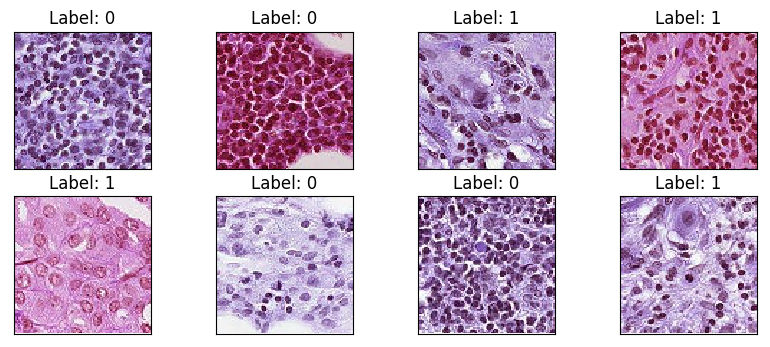

In [ ]:
fig = plt.figure(figsize=(10, 4), dpi=100)
np.random.seed(42) #we can use the seed to get a different set of random images
for plotnr,idx in enumerate(np.random.randint(0, n, 8)):
    ax = fig.add_subplot(2, 8//2, plotnr+1, xticks=[], yticks=[]) #add subplots
    plt.imshow(X[idx]) #plot image
    ax.set_title('Label: ' + str(y[idx])) #show the label corresponding to the image

## Data distribution

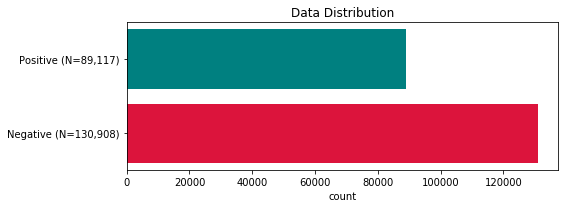

In [ ]:
neg_count = len(df[df['label'] == 0])
pos_count = len(df[df['label'] == 1])

labels = [f"Negative (N={neg_count:,})",f"Positive (N={pos_count:,})"]
values = [neg_count, pos_count]

plt.figure(figsize=(8, 3))
plt.barh(labels, values, color=['crimson', 'teal'])
plt.xlabel("count")
plt.title("Data Distribution")
# Add value labels
# for i, v in enumerate(values):
#     plt.text(v + 1, i, f"{v}%", va="center")
plt.tight_layout()
plt.show()

In [ ]:
positive_samples = X[y == 1]
negative_samples = X[y == 0]

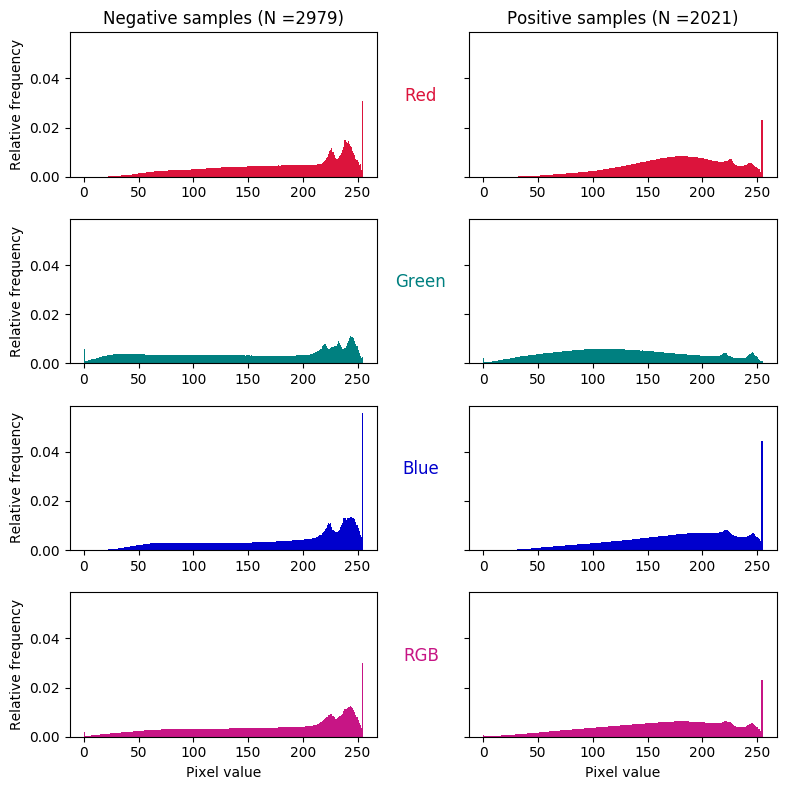

In [ ]:
nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=100)

#RGB channels
axs[0,0].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True, color='crimson')
axs[0,1].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True, color='crimson')
axs[1,0].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True, color='teal')
axs[1,1].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True, color='teal')
axs[2,0].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True, color='mediumblue')
axs[2,1].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True, color='mediumblue')

#All channels
axs[3,0].hist(negative_samples.flatten(),bins=nr_of_bins,density=True, color='mediumvioletred')
axs[3,1].hist(positive_samples.flatten(),bins=nr_of_bins,density=True, color='mediumvioletred')

#Set image labels
axs[0,0].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
axs[0,1].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12, color='crimson')
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12, color='teal')
axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12, color='mediumblue')
axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12, color='mediumvioletred')
for i in range(4):
    axs[i,0].set_ylabel("Relative frequency")
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")
fig.tight_layout()

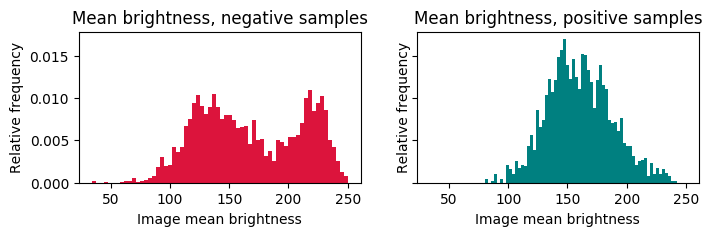

In [ ]:
nr_of_bins = 64 #we use a bit fewer bins to get a smoother image
fig, axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=100)
axs[0].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True, color='crimson')
axs[1].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True, color='teal')
axs[0].set_title("Mean brightness, negative samples");
axs[1].set_title("Mean brightness, positive samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");

## Data cleaning procedures

* Remove corrupt or mis-sized images, duplicates, and inconsistent label entries.
* Detect and handle low-information patches.
* Account for class imbalance with weighted losses or sampling.
* Normalize inputs and apply center-aware preprocessing.

# 3. Model Architecture

**Used Model**: SimpleCNN   
Reason: ResNet-18 has more prameters and is genellay easier to fit, but SimpleCNN's Private LB outperforms ResNet-18, which appears to overfit.

| Model (input)           | Params (approx) | Pros                              | Cons / Risks                          | Expectation             |
| ----------------------- | --------------: | --------------------------------- | ------------------------------------- | ----------------------- |
| SimpleCNN (128)         |          \~3–4M | Fast, great for ablations         | Ceiling may be lower                  | Solid baseline          |
| ResNet-18 (128, pt)     |           \~11M | Strong transfer, stable training  | Heavier than SimpleCNN                | Best first choice       |



**Structure:**  
SimpleCNN (baseline; in canvas)  
4 Conv blocks (3×3 convs + BN + ReLU) with downsampling (MaxPool) and AdaptiveAvgPool2d(1) → FC(256→1)

```
SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): ReLU(inplace=True)
    (17): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (18): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (19): ReLU(inplace=True)
    (20): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (21): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (22): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (23): ReLU(inplace=True)
    (24): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (25): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (26): ReLU(inplace=True)
    (27): AdaptiveAvgPool2d(output_size=1)
  )
  (head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
)
```

# 4. Results and Analysis

### Hyperparameter, improvement

* **Make some changes to the base configuration and analyze the performance results.**
* **Depending on the performance results, change the epochs from the base configuration to 15.**

\[Base Configuration]  
model: SimpleCNN  
dropout: 0.3  
loss function: BCEWithLogits


<div align="left">
    
| Change| Value | train-loss | val-loss | Local AUC | LB Public | LB Private |
|-------|----------|:----------:|:--------:|:---------:|:---------:|:----------:|
| *Base |  | 0.2000 | 0.1777 | 0.9879 | 0.9672 | 0.9606 |
| model | Resnet-18 | 0.0927 | 0.0924 | 0.9958 | 0.9640 | 0.9562 |
| loss function | Focal | 0.0436 | 0.0368 | 0.9883 | 0.9651 | 0.9603 |
| dropout | 0.4 | 0.1993 | 0.1623 | 0.9882 | 0.9594 | 0.9597 |
| **epoch** | **15** | 0.1619 | 0.1466 | 0.9906 | 0.9544 | **0.9678** |

</div>

**Model(vs. ResNet-18)**
ResNet-18 has a deeper architecture than SimpleCNN, so it may be overfitting or the epochs (= 8) may be too short.

**Loss Function(vs. Focal)**  
BCE≧Focal because imbalance may be not severe.

**Dropout(vs. 0.4)**  
0.4 dropout may be just a bit too much regularization for your 8-epoch regime, so you’re shaving off useful signal.

**Epoch(vs. 15)**  
This model just might need more optimization steps to learn the subtle, center-driven textures—so with 15 epochs it converged to a better ranking function, hence higher AUC.



# 5. Conclusion

## What Helped

* Using BCE with class weighting: stable, simple, effective.
* Dropout ~0.3: adds enough regularization without hurting feature retention.
* Longer training (≥15 epochs): gave significant performance boost, no overfitting observed.
* Simple CNN: surprisingly competitive due to inductive bias aligned with the task.

## What Didn’t Help

* Focal loss (default γ=2): didn’t outperform BCE in this setting.
* Higher dropout (0.4): too much regularization → slightly worse AUC.
* ResNet-18 (default fine-tuning): underperformed relative to the lighter custom CNN.

## Future Improvements to Try

1. Training Strategy
    * Use longer schedules (20–25 epochs) with early stopping on validation AUC.
    * Two-phase training for ResNet: freeze → unfreeze with reduced LR.
2. Data Augmentation
    * Stain normalization (Macenko/Vahadane methods) to reduce domain shift.
    * Subtle elastic transforms to mimic tissue variation.
3. Architecture Tweaks
    * Try EfficientNet-B0 or ConvNeXt-Tiny: lightweight, often outperform ResNet on small-med images.
    * Experiment with SpatialDropout2d (early layers) instead of just head dropout.
4. Loss & Sampling
    * Grid search on Focal γ (0.5–2.0), adjusting α by class ratio.
    * Explore BalancedBatchSampler to ensure consistent positive/negative mix per mini-batch.
5. Ensembling
    * Blend SimpleCNN + ResNet18 + EfficientNet predictions (average logits). Often boosts AUC in Kaggle histology comps.